In [2]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
print(tf.__version__)

1.15.0


In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data","http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 1us/step


'/root/.keras/datasets/auto-mpg.data'

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration','Model Year','Origin']
raw_dataset = pd.read_csv(dataset_path,names=column_names,
                          na_values = "?", comment='\t', 
                          sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
dataset = raw_dataset.copy()
print(dataset.shape)
dataset = dataset.dropna()
print(dataset.shape)

(398, 8)
(392, 8)


In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
origin = dataset.pop('Origin')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
393,27.0,4,140.0,86.0,2790.0,15.6,82
394,44.0,4,97.0,52.0,2130.0,24.6,82
395,32.0,4,135.0,84.0,2295.0,11.6,82
396,28.0,4,120.0,79.0,2625.0,18.6,82
397,31.0,4,119.0,82.0,2720.0,19.4,82


In [9]:
np.unique(origin)

array([1, 2, 3])

In [10]:
origin == 1

0       True
1       True
2       True
3       True
4       True
       ...  
393     True
394    False
395     True
396     True
397     True
Name: Origin, Length: 392, dtype: bool

In [11]:
(origin == 1)*1.0

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
393    1.0
394    0.0
395    1.0
396    1.0
397    1.0
Name: Origin, Length: 392, dtype: float64

In [0]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0

In [13]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [14]:
train_dataset = dataset.sample(frac=0.8, random_state=0) # 80%
train_dataset.index
# ctrl + f10

Int64Index([146, 282,  69, 378, 331, 257, 310, 328, 125, 108,
            ...
            171,  70, 307,  49, 209, 281, 229, 150, 145, 182],
           dtype='int64', length=314)

In [0]:
test_dataset = dataset.drop(train_dataset.index) # 20%

In [16]:
train_dataset.shape

(314, 10)

In [17]:
test_dataset.shape

(78, 10)

In [18]:
train_dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,23.310510,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089,0.624204,0.178344,0.197452
std,7.728652,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642,0.485101,0.383413,0.398712
min,10.000000,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000,0.000000,0.000000,0.000000
50%,22.000000,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000,1.000000,0.000000,0.000000
75%,28.950000,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000,1.000000,0.000000,0.000000
max,46.600000,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


# MPG 예측하기

In [19]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

train_labels.head()


146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
Name: MPG, dtype: float64

In [20]:
test_labels.head()

9     15.0
25    10.0
28     9.0
31    25.0
33    19.0
Name: MPG, dtype: float64

In [0]:
train_stats = train_dataset.describe()
train_stats.pop("USA")
train_stats.pop("Europe")
train_stats.pop("Japan")
train_stats = train_stats.transpose()


In [22]:
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


In [23]:
train_dataset.columns

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'USA', 'Europe', 'Japan'],
      dtype='object')

In [0]:
def norm(x):
    return((x - train_stats['mean']) / train_stats['std'])
norm_col_list = ['Cylinders','Displacement','Horsepower','Weight','Acceleration','Model Year']
train_dataset[norm_col_list] = norm(train_dataset[norm_col_list])

In [25]:
train_dataset.describe()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
count,3.140000e+02,3.140000e+02,3.140000e+02,3.140000e+02,3.140000e+02,3.140000e+02,314.000000,314.000000,314.000000
mean,2.093159e-16,1.018294e-16,-1.909301e-17,-9.723291e-17,2.688832e-15,9.561531e-16,0.624204,0.178344,0.197452
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.485101,0.383413,0.398712
min,-1.457657e+00,-1.220325e+00,-1.545283e+00,-1.589352e+00,-2.710152e+00,-1.604642e+00,0.000000,0.000000,0.000000
25%,-8.693480e-01,-8.608943e-01,-7.512407e-01,-8.694784e-01,-6.307245e-01,-7.884578e-01,0.000000,0.000000,0.000000
50%,-8.693480e-01,-4.247848e-01,-2.721905e-01,-1.987817e-01,-2.123729e-02,2.772599e-02,1.000000,0.000000,0.000000
75%,1.483887e+00,6.750739e-01,6.071620e-01,7.320173e-01,5.882500e-01,8.439098e-01,1.000000,0.000000,0.000000
max,1.483887e+00,2.489002e+00,3.153347e+00,2.547401e+00,3.313017e+00,1.660094e+00,1.000000,1.000000,1.000000


In [26]:
np.mean((train_labels - np.mean(train_labels))/np.std(train_labels))

2.7720218194462506e-16

In [27]:
np.std((train_labels - np.mean(train_labels))/np.std(train_labels))

1.0000000000000002

In [0]:
test_labels = (test_labels - np.mean(train_labels))/np.std(train_labels)

In [0]:
train_labels = (train_labels - np.mean(train_labels))/np.std(train_labels)

In [0]:
test_dataset[norm_col_list] = norm(test_dataset[norm_col_list])

# model 만들기

In [31]:
train_dataset

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,1.0,0.0,0.0
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,1.0,0.0,0.0
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,1.0,0.0,0.0
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,1.0,0.0,0.0
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,1.0,0.0,0.0
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,1.0,0.0,0.0
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,0.0,0.0,1.0
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,0.0,0.0,1.0


In [32]:
def build_model():
    model = keras.Sequential([
                        layers.Dense(64,activation='relu', input_shape=[len(train_dataset.keys())]),
                        layers.Dense(64,activation='relu'),
                        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.SGD(0.01)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae','mse'])

    return model


model = build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [41]:
64*64 + 64

4160

In [0]:
import time

In [40]:
start_time = time.time()
history = model.fit(train_dataset, train_labels, epochs=100)
print(time.time()-start_time)

Train on 314 samples
Epoch 1/100
314/314 [==============================] - 0s 91us/sample - loss: 0.1033 - mean_absolute_error: 0.2285 - mean_squared_error: 0.1033
Epoch 2/100
314/314 [==============================] - 0s 71us/sample - loss: 0.1030 - mean_absolute_error: 0.2290 - mean_squared_error: 0.1030
Epoch 3/100
314/314 [==============================] - 0s 71us/sample - loss: 0.1023 - mean_absolute_error: 0.2277 - mean_squared_error: 0.1023
Epoch 4/100
314/314 [==============================] - 0s 76us/sample - loss: 0.1027 - mean_absolute_error: 0.2278 - mean_squared_error: 0.1027
Epoch 5/100
314/314 [==============================] - 0s 75us/sample - loss: 0.1019 - mean_absolute_error: 0.2276 - mean_squared_error: 0.1019
Epoch 6/100
314/314 [==============================] - 0s 88us/sample - loss: 0.1036 - mean_absolute_error: 0.2298 - mean_squared_error: 0.1036
Epoch 7/100
314/314 [==============================] - 0s 91us/sample - loss: 0.1013 - mean_absolute_error: 0.2264 

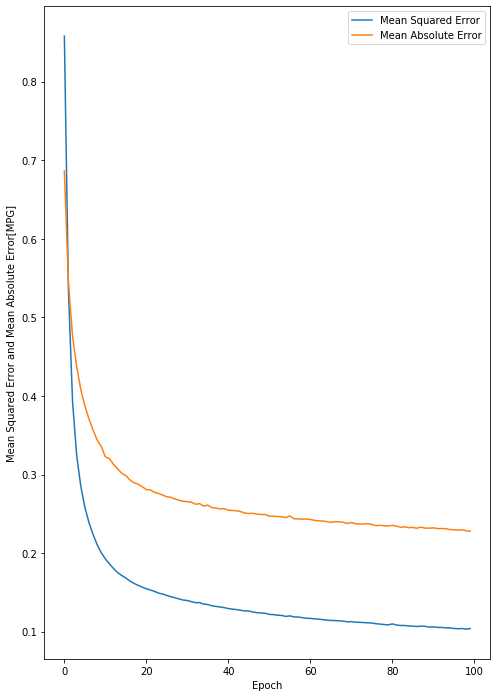

In [36]:
import matplotlib.pyplot as plt

hist = pd.DataFrame(history.history)
#   hist['epoch'] = history.epoch

plt.figure(figsize=(8,12))

plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error and Mean Absolute Error[MPG]')
plt.plot(hist['mean_squared_error'], label='Mean Squared Error')
plt.plot(hist['mean_absolute_error'], label='Mean Absolute Error')
plt.legend()



In [37]:
hist

,loss,mean_absolute_error,mean_squared_error
0,0.858010,0.686377,0.858009
1,0.533077,0.543599,0.533077
2,0.392751,0.475849,0.392751
3,0.324271,0.437626,0.324271
4,0.285440,0.408476,0.285440
...,...,...,...
95,0.104053,0.229654,0.104053
96,0.103673,0.229219,0.103673
97,0.104011,0.229658,0.104011
98,0.103188,0.228494,0.103188


In [0]:
train_dataset.to_csv("abd")

In [39]:
!ls

abd  sample_data
